In [1]:
import pandas as pd
import numpy as np
import glob
import soundfile
import os
import sys

In [2]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Audio

In [5]:
RavdessData = "C:\\Users\\Anwesha Borah\\Desktop\\New folder\\speech-emotion-recognition-ravdess-data\\"
RavdessData

'C:\\Users\\Anwesha Borah\\Desktop\\New folder\\speech-emotion-recognition-ravdess-data\\'

In [6]:
ravdessDirectoryList = os.listdir(RavdessData)
fileEmotion = []
filePath = []
for dir in ravdessDirectoryList:
    actor = os.listdir(RavdessData + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        fileEmotion.append(int(part[2]))
        filePath.append(RavdessData + dir + '/' + file)        
emotion_df = pd.DataFrame(fileEmotion, columns=['Emotions'])
path_df = pd.DataFrame(filePath, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1 )


In [7]:
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


,Emotions,Path
0,neutral,C:\Users\Anwesha Borah\Desktop\New folder\spee...
1,neutral,C:\Users\Anwesha Borah\Desktop\New folder\spee...
2,neutral,C:\Users\Anwesha Borah\Desktop\New folder\spee...
3,neutral,C:\Users\Anwesha Borah\Desktop\New folder\spee...
4,calm,C:\Users\Anwesha Borah\Desktop\New folder\spee...


In [15]:
dataPath = pd.concat([Ravdess_df], axis = 0)
dataPath.to_csv("data_path.csv",index=False)


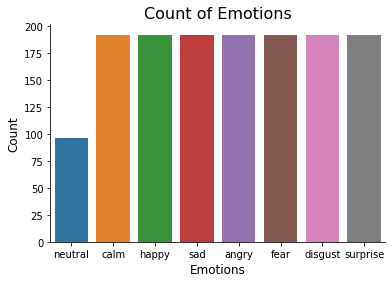

In [16]:
plt.title('Count of Emotions', size=16)
sns.countplot(dataPath.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [17]:
def createWaveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()


In [18]:
def createSpectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()


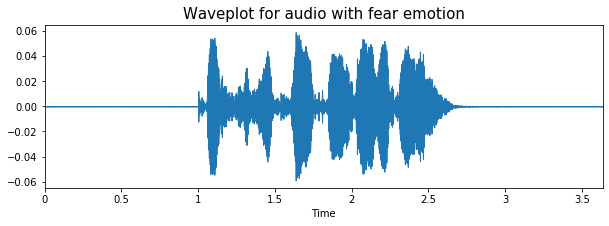

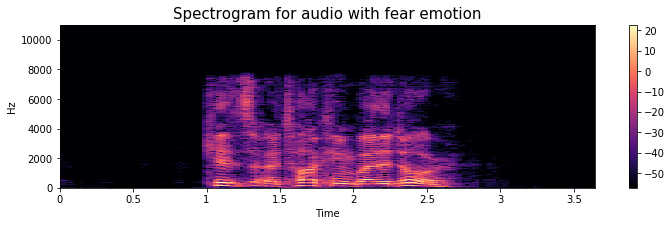

In [19]:
emotion='fear'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, samplingRate = librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
Audio(path)


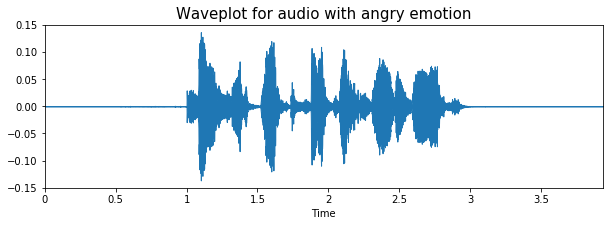

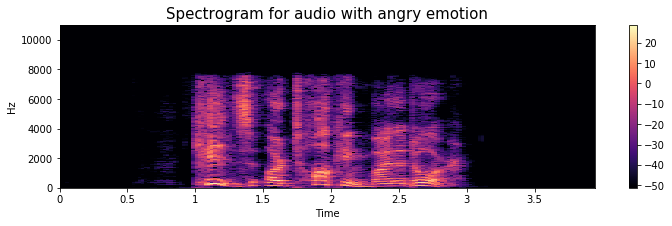

In [13]:
emotion='angry'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, samplingRate = librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
Audio(path)


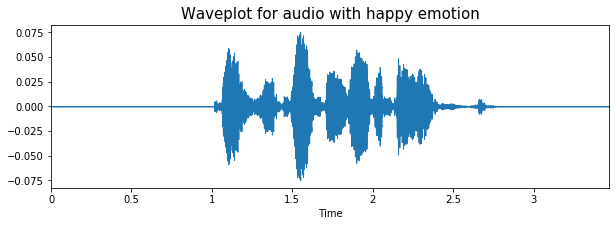

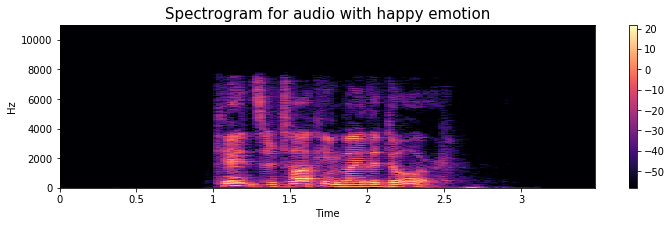

In [14]:
emotion='happy'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, samplingRate = librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
Audio(path)


In [20]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [21]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# Emotions to observe
observed_emotions=['calm', 'happy', 'sad', 'angry']

In [22]:
# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [23]:
 # load RAVDESS dataset, 80% training 20% testing
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [24]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", x_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", x_test.shape[0])
# number of features used
# this is a vector of features extracted 
# using extract_features() function
print("[+] Number of features:", x_train.shape[1])

[+] Number of training samples: 614
[+] Number of testing samples: 154
[+] Number of features: 180


In [25]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [26]:
# Train the model
model.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [27]:
# Predict for the test set
expected_Of_y = y_test
y_pred=model.predict(x_test)

In [28]:
print(metrics.confusion_matrix(expected_Of_y, y_pred))

[[26  2 10  3]
 [ 0 28  2 14]
 [ 2  0 30  4]
 [ 0  2  4 27]]


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.93      0.63      0.75        41
        calm       0.88      0.64      0.74        44
       happy       0.65      0.83      0.73        36
         sad       0.56      0.82      0.67        33

    accuracy                           0.72       154
   macro avg       0.75      0.73      0.72       154
weighted avg       0.77      0.72      0.73       154



In [30]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 72.08%


In [31]:
import pickle
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(model, open("result/mlp_classifier.model", "wb"))

In [32]:
import pyaudio
import os
import wave
import pickle
from sys import byteorder
from array import array
from struct import pack
from sklearn.neural_network import MLPClassifier

from utils.extract_feature import extract_feature

THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 16000

SILENCE = 30

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

def record():
    p = pyaudio.PyAudio() # create an interface to PortAudio
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False
    r = array('h')
    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)
        silent = is_silent(snd_data)
        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True
        if snd_started and num_silent > SILENCE:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()
    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r


In [33]:
def record_to_file(path):
   
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()



if __name__ == "__main__":
    # load the saved model (after training)
    model = pickle.load(open("result/mlp_classifier.model", "rb"))
    print("Please talk")
    filename = "test.wav"
    # record the file (start talking)
    record_to_file(filename)
    # extract features and reshape it
    features = extract_feature(filename, mfcc=True, chroma=True, mel=True).reshape(1, -1)
    # predict
    result = model.predict(features)[0]
    # show the result !
    print("result:", result)

Please talk
result: happy
